In [ ]:
#x02_chewc

In [ ]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid

In [ ]:
import torch

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes=None, device='cpu'):
        self.g = genome
        self.device = device
        if haplotypes:
            self.haplotypes=haplotypes
        else:
            self.haplotypes = self._create_random_haplotypes(500)
        self._calculate_dosages()
            
    def _calculate_dosages(self):
        self.dosages = self.haplotypes.sum(dim=1).float()
        
    def _create_random_haplotypes(self,num_individuals):
        return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
    
    def __getitem__(self,index):
        return self.haplotypes[index]
    
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device='cpu'):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean


def calculate_breeding_value(population_dosages, trait_effects):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)
        
G = Genome(50,10)
P = Population(genome=G)
T = Trait(G,P, 0, 1)

In [ ]:
def phenotype(population_dosages, trait_effects, h2):
    breeding_values = torch.einsum('hjk,jk->h', population_dosages,trait_effects)
    environmental_variance = (1 - h2) / h2 * breeding_values.var()
    environmental_noise = torch.randn(breeding_values.shape) * torch.sqrt(torch.tensor(environmental_variance))
    return breeding_values + environmental_noise

/tmp/ipykernel_151533/463781258.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  environmental_noise = torch.randn(breeding_values.shape) * torch.sqrt(torch.tensor(environmental_variance))


(array([  6.,  30.,  67., 117., 123.,  92.,  49.,  11.,   4.,   1.]),
 array([-4.02730608, -3.0871346 , -2.14696312, -1.20679164, -0.26662016,
         0.67355132,  1.6137228 ,  2.55389428,  3.49406576,  4.43423748,
         5.37440872]),
 <BarContainer object of 10 artists>)

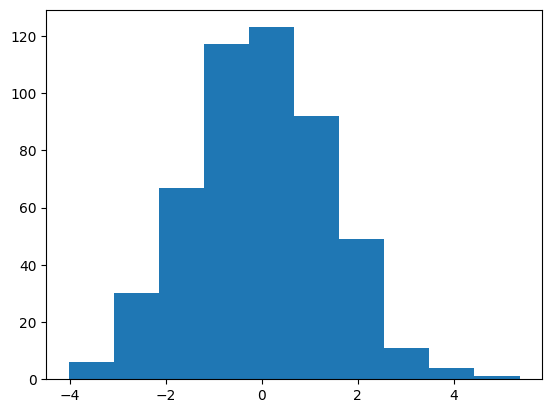

In [ ]:
plt.hist(phenotype(P.dosages, T.effects, .5))